In [1]:
import pickle
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from functions import get_movies_scores, get_infos, get_X
from variable_selection_metrics import user_questions, random_questions, loop_simulation, metrics_simulations, pre_compute_tree
from metrics import random_forest, forward_feature_selection, backward_feature_elimination, random_variable_choice, variable_mean_choice

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Load data

In [4]:
artists = pd.read_csv("data/hetrec2011-lastfm-2k/artists.dat", sep="\t", usecols=['id', 'name', 'url', 'pictureURL'])

In [5]:
with open("data/hetrec2011-lastfm-2k/tags.dat") as f:
    lines = f.readlines()
    ids = []
    values = []
    for i, line in enumerate(lines[1:]):
        ids.append(line.strip().split("\t")[0])
        values.append(line.strip().split("\t")[1])
    tags = pd.DataFrame({'tagID': ids, 'tagValue': values})

In [6]:
user_artists = pd.read_csv("data/hetrec2011-lastfm-2k/user_artists.dat", sep="\t", usecols=['userID', 'artistID', 'weight'])

In [7]:
user_friends = pd.read_csv("data/hetrec2011-lastfm-2k/user_friends.dat", sep="\t", usecols=['userID', 'friendID'])

In [8]:
user_taggedartists = pd.read_csv("data/hetrec2011-lastfm-2k/user_taggedartists.dat", sep="\t", usecols=['userID', 'artistID', 'tagID', 'day', 'month', 'year'])

In [9]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [10]:
user_artists

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [11]:
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [12]:
tags.tagID = tags.tagID.transform(int)

In [13]:
user_taggedartists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


# Data cleaning

- Plotting tag occurence and removing less represented
- Compute time of algorithms
- Compute correlation matrix of tags
- Remove of the tag with too high correlation
- Compute time again

In [14]:
tags.size

23892

In [15]:
user_taggedartists.tagID.unique().size

9749

### Il y a la moitié des tags qui ne sont même pas utilisés

Regardons la répartition des tags et coupons les moins utiles

In [16]:
usefull_tags = user_taggedartists.tagID.unique().copy()

In [17]:
counts = user_taggedartists.tagID.value_counts()
counts

73      7503
24      5418
79      5251
18      4672
81      4458
        ... 
7620       1
7748       1
5701       1
1607       1
2049       1
Name: tagID, Length: 9749, dtype: int64

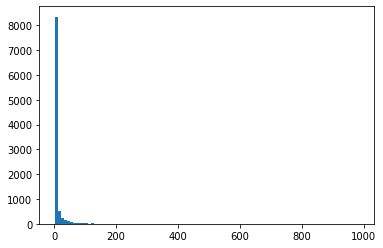

In [18]:
plt.hist(counts[counts < 1000], bins=100)
plt.show()

In [19]:
counts[counts > 10].size

1403

In [20]:
counts[counts > 500].size

73

In [125]:
selected = counts[counts > 500].index

In [126]:
selected

Int64Index([ 73,  24,  79,  18,  81, 130,  25,  39,  78, 192, 195,  84, 134,
             72,  33,   1,  14, 352,  16, 127,  13, 102, 181, 292, 187, 167,
            191, 386, 625, 185, 387, 735,  83, 184, 306,  61,  21, 376, 103,
             74, 216, 194, 296, 109, 210, 389, 275, 247, 182, 829,  88,  15,
            213, 238,  91,  47,  87, 309, 285, 508, 824, 850,   5,  49, 180,
            432, 234, 169, 193,  86,  76, 176, 304],
           dtype='int64')

In [74]:
selected_tags = tags[[(i in selected) for i in tags.tagID]]

In [75]:
selected_tags

,tagID,tagValue
0,1,metal
4,5,death metal
12,13,chillout
13,14,ambient
14,15,downtempo
...,...,...
618,625,soul
728,735,70s
817,824,mellow
822,829,blues


In [76]:
values = selected_tags.tagValue

In [77]:
selected_tags.index

Int64Index([  0,   4,  12,  13,  14,  15,  17,  20,  23,  24,  32,  38,  46,
             48,  60,  71,  72,  73,  75,  77,  78,  80,  82,  83,  85,  86,
             87,  90, 101, 102, 108, 126, 129, 133, 166, 168, 175, 179, 180,
            181, 183, 184, 186, 190, 191, 192, 193, 194, 209, 212, 215, 233,
            237, 246, 274, 284, 291, 295, 303, 305, 308, 345, 369, 379, 380,
            382, 425, 501, 618, 728, 817, 822, 843],
           dtype='int64')

In [78]:
meaningless_tags = ["chillout", "ambient", "downtempo", "seen live", "beautiful", "amazing", "sexy", "awesome", "cover", "mellow"]
meaningless_tagIDs = []

In [79]:
for t in meaningless_tags:
    meaningless_tagIDs.append(selected_tags[selected_tags.tagValue == t].index[0])

In [80]:
meaningless_tagIDs

[12, 13, 14, 126, 212, 233, 237, 284, 843, 817]

In [81]:
selected_tags.drop(meaningless_tagIDs)

,tagID,tagValue
0,1,metal
4,5,death metal
15,16,new wave
17,18,electronic
20,21,trip-hop
...,...,...
425,432,brazilian
501,508,love
618,625,soul
728,735,70s


In [82]:
selected_tags[selected_tags.tagValue == "idm"]

,tagID,tagValue
46,47,idm


In [83]:
selected_tags.iloc[46]

tagID            194
tagValue    hardcore
Name: 193, dtype: object

In [ ]:
2
chillout
3
ambient
4
downtempo
31
seen live
49
beautiful
51
amazing
52
sexy
55
awesome
72
cover
70
mellow

12
idm -> intelligent dance (music)
24
ebm -> electronic body (music)
48
00s -> 2000's 

In [84]:
names_to_replace = {"idm": "intelligent dance", "ebm":"electronic body", "00s": "2000s"}

In [108]:
ids, values = selected_tags.tagID.values, selected_tags.tagValue.values

In [109]:
values

array(['metal', 'death metal', 'chillout', 'ambient', 'downtempo',
       'new wave', 'electronic', 'trip-hop', 'pop', '80s', 'experimental',
       'dance', 'intelligent dance', 'female vocalist', 'industrial',
       'hard rock', 'rock', 'synthpop', 'progressive metal',
       'alternative rock', 'alternative', 'indie', 'jazz', 'indie rock',
       'electronic body', 'post-rock', 'psychedelic', 'thrash metal',
       'hip-hop', 'rap', 'pop rock', 'seen live', 'female vocalists',
       'singer-songwriter', 'rnb', 'pop punk', 'emo', 'post-hardcore',
       'punk', 'punk rock', 'soundtrack', 'acoustic', 'electronica',
       'instrumental', 'classic rock', 'country', 'hardcore', 'british',
       '2000s', 'beautiful', 'american', 'amazing', 'sexy', '60s',
       'post-punk', 'awesome', 'folk', 'indie pop', 'hip hop',
       'male vocalists', 'electro', '90s', 'metalcore', 'heavy metal',
       'progressive rock', 'britpop', 'brazilian', 'love', 'soul', '70s',
       'mellow', 'blues', 

In [110]:
"iedm" in names_to_replace.keys()

False

In [111]:
for i, v in enumerate(values):
    if v in names_to_replace.keys():
        values[i] = names_to_replace[v]

In [112]:
values

array(['metal', 'death metal', 'chillout', 'ambient', 'downtempo',
       'new wave', 'electronic', 'trip-hop', 'pop', '80s', 'experimental',
       'dance', 'intelligent dance', 'female vocalist', 'industrial',
       'hard rock', 'rock', 'synthpop', 'progressive metal',
       'alternative rock', 'alternative', 'indie', 'jazz', 'indie rock',
       'electronic body', 'post-rock', 'psychedelic', 'thrash metal',
       'hip-hop', 'rap', 'pop rock', 'seen live', 'female vocalists',
       'singer-songwriter', 'rnb', 'pop punk', 'emo', 'post-hardcore',
       'punk', 'punk rock', 'soundtrack', 'acoustic', 'electronica',
       'instrumental', 'classic rock', 'country', 'hardcore', 'british',
       '2000s', 'beautiful', 'american', 'amazing', 'sexy', '60s',
       'post-punk', 'awesome', 'folk', 'indie pop', 'hip hop',
       'male vocalists', 'electro', '90s', 'metalcore', 'heavy metal',
       'progressive rock', 'britpop', 'brazilian', 'love', 'soul', '70s',
       'mellow', 'blues', 

In [113]:
selected_tags = pd.DataFrame({'tagID': ids, 'tagValue': values})

In [114]:
selected_tags.tagValue.values

array(['metal', 'death metal', 'chillout', 'ambient', 'downtempo',
       'new wave', 'electronic', 'trip-hop', 'pop', '80s', 'experimental',
       'dance', 'intelligent dance', 'female vocalist', 'industrial',
       'hard rock', 'rock', 'synthpop', 'progressive metal',
       'alternative rock', 'alternative', 'indie', 'jazz', 'indie rock',
       'electronic body', 'post-rock', 'psychedelic', 'thrash metal',
       'hip-hop', 'rap', 'pop rock', 'seen live', 'female vocalists',
       'singer-songwriter', 'rnb', 'pop punk', 'emo', 'post-hardcore',
       'punk', 'punk rock', 'soundtrack', 'acoustic', 'electronica',
       'instrumental', 'classic rock', 'country', 'hardcore', 'british',
       '2000s', 'beautiful', 'american', 'amazing', 'sexy', '60s',
       'post-punk', 'awesome', 'folk', 'indie pop', 'hip hop',
       'male vocalists', 'electro', '90s', 'metalcore', 'heavy metal',
       'progressive rock', 'britpop', 'brazilian', 'love', 'soul', '70s',
       'mellow', 'blues', 

## Etude de la matrice de corrélation

In [124]:
selected.remove(meaningless_tagIDs)

ValueError: list.remove(x): x not in list

In [132]:
meaningless_tagIDs

[12, 13, 14, 126, 212, 233, 237, 284, 843, 817]

In [137]:
s = list(selected)

In [138]:
12 in s

False

In [139]:
s

[73,
 24,
 79,
 18,
 81,
 130,
 25,
 39,
 78,
 192,
 195,
 84,
 134,
 72,
 33,
 1,
 14,
 352,
 16,
 127,
 13,
 102,
 181,
 292,
 187,
 167,
 191,
 386,
 625,
 185,
 387,
 735,
 83,
 184,
 306,
 61,
 21,
 376,
 103,
 74,
 216,
 194,
 296,
 109,
 210,
 389,
 275,
 247,
 182,
 829,
 88,
 15,
 213,
 238,
 91,
 47,
 87,
 309,
 285,
 508,
 824,
 850,
 5,
 49,
 180,
 432,
 234,
 169,
 193,
 86,
 76,
 176,
 304]

In [140]:
selected_user_taggedartists = user_taggedartists[[(i in selected and not i-1 in meaningless_tagIDs) for i in user_taggedartists.tagID]]

In [141]:
selected_user_taggedartists.tagID.unique().size

65

In [131]:
selected_user_taggedartists

,userID,artistID,tagID,day,month,year
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
11,2,73,15,1,4,2009
12,2,73,18,1,4,2009
...,...,...,...,...,...,...
186451,2099,18716,15,1,10,2009
186454,2099,18717,15,1,2,2010
186457,2099,18721,15,1,1,2009
186462,2099,18724,15,1,2,2010


In [28]:
def create_experiment_df(user_artists, tags, user_taggedartists):
    weights = user_artists.weight
    maxw = np.max(weights)
    threshold = np.exp(0.5 * np.log(maxw))
    ratings = np.zeros(weights.size, dtype=int)
    for i in range(len(ratings)):
        ratings[i] = (-5) * np.log(weights.iloc[i] / maxw) / np.log(maxw)
    
    experiment_dict = {
        "item":user_artists.artistID,
        "user":user_artists.userID,
        "rating":ratings,
    }
    
    l = user_artists.artistID.size
    for tag in tags.tagID:
        experiment_dict[int(tag)] = np.zeros(l, dtype=int)
    
    for i in range(user_taggedartists.userID.size):
        experiment_dict[user_taggedartists.tagID.iloc[i]][user_artists.artistID == user_taggedartists.artistID.iloc[i]] += 1
        
    experiment_df = pd.DataFrame(experiment_dict)
    
    return experiment_df

In [29]:
sel_exp_df = create_experiment_df(user_artists, selected_tags, selected_user_taggedartists)

In [30]:
sel_exp_df.head()

,item,user,rating,1,5,13,14,15,16,18,...,386,387,389,432,508,625,735,824,829,850
0,51,2,1,0,0,1,1,0,38,6,...,0,0,3,0,2,0,0,2,0,3
1,52,2,1,0,0,10,0,7,0,6,...,0,0,0,0,0,0,0,0,0,0
2,53,2,1,0,0,16,16,7,0,31,...,0,0,0,0,1,0,0,3,0,0
3,54,2,1,0,0,8,1,4,0,8,...,0,0,0,0,0,0,0,1,0,0
4,55,2,1,0,0,1,0,0,1,27,...,0,0,0,0,2,2,0,1,0,0


In [30]:
correlations = get_X(sel_exp_df).corr()

In [44]:
to_remove = set()
X = get_X(sel_exp_df)
for i in correlations.columns:
    for j in correlations.columns:
        if i > j and correlations.loc[i][j] > 0.8:
            if X.loc[i].sum() > X.loc[j].sum():
                to_remove.add(j)
            else :
                to_remove.add(i)

In [45]:
selected_tags_v2 = selected_tags[[(i not in to_remove) for i in selected_tags.tagID]]

In [46]:
selected_user_taggedartists_v2 = selected_user_taggedartists[[(i not in to_remove) for i in selected_user_taggedartists.tagID]]

In [47]:
selected_user_taggedartists_v2.tagID.unique().size

194

In [36]:
sel_exp_df_v2 = create_experiment_df(user_artists, selected_tags_v2, selected_user_taggedartists_v2)

# Create usable data (skip if data available)

Weight (amount of listening of an artist from an user) convert to a rating (0 or 5) to fit functions

In [ ]:
experiment_df = create_experiment_df(user_artists, tags, user_taggedartists)

In [ ]:
experiment_df.head()

In [39]:
filename = 'experiment_clean_lastfm.pkl'
outfile = open(filename,'wb')
pickle.dump(sel_exp_df,outfile,protocol=4)
outfile.close()

In [95]:
filename = 'experiment_small_lastfm.pkl'
outfile = open(filename,'wb')
pickle.dump(sel_exp_df,outfile,protocol=4)
outfile.close()

In [31]:
filename = 'selected_user_taggedartists.pkl'
outfile = open(filename,'wb')
pickle.dump(selected_user_taggedartists,outfile,protocol=4)
outfile.close()

# Load experiment data (skip if not generated)

In [ ]:
pkl = open('experiment_lastfm.pkl','rb')
experiment_df = pickle.load(pkl)
pkl.close()

# Create question from variable

In [44]:
def question_about_music(variable, tags):
    return "Do you like " + str(tags[tags.tagID == variable].tagValue.iloc[0]) + " music? (y/n)"

In [43]:
tags[tags.tagID == 25].tagValue.iloc[0]

'80s'

In [45]:
question_about_music(325, tags)

'Do you like ft music? (y/n)'

# Create preprocess trees

In [31]:
df = sel_exp_df.copy()
for c in get_X(sel_exp_df):
    df[c][df[c] >= 1] = 1

C:\Users\Visiteur\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [197]:
t10rf = pre_compute_tree(df, random_forest, depth = 10)
t10ffs = pre_compute_tree(df, forward_feature_selection, depth = 10)
t10rvc = pre_compute_tree(df, random_variable_choice, depth = 10)
t10vmc = pre_compute_tree(df, variable_mean_choice, depth = 10)

C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWa

C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater

In [198]:
trees = {"RF":t10rf, "FFS":t10ffs, "RVC":t10rvc, "VMC":t10vmc}

In [204]:
t10rf.v

127

In [200]:
t10ffs.v

79

In [201]:
t10rvc.v

79

In [202]:
t10vmc.v

73

In [205]:
tags[tags.tagID == 127]

,tagID,tagValue
126,127,seen live


# Experiments

In [206]:
df.item.unique().size

17632

In [207]:
df.user.unique().size

1892

In [208]:
df.columns.size

76

In [209]:
#user_result = user_questions(df, random_variable_choice)

In [217]:
metric_list = [random_forest, forward_feature_selection, random_variable_choice, variable_mean_choice]
metric_names = ["RF", "FFS", "RVC", "VMC"]

loopsize = 20

In [215]:
df.columns

Index([  'item',   'user', 'rating',        1,        5,       13,       14,
             15,       16,       18,       21,       24,       25,       33,
             39,       47,       49,       61,       72,       73,       74,
             76,       78,       79,       81,       83,       84,       86,
             87,       88,       91,      102,      103,      109,      127,
            130,      134,      167,      169,      176,      180,      181,
            182,      184,      185,      187,      191,      192,      193,
            194,      195,      210,      213,      216,      234,      238,
            247,      275,      285,      292,      296,      304,      306,
            309,      352,      376,      386,      387,      389,      432,
            508,      625,      735,      824,      829,      850],
      dtype='object')

In [218]:
results, times, question_counts = metrics_simulations(df, metric_list, metric_names, loopsize, display=True, trees = trees)

 ========== RF ========== 
k = 0
k = 5
k = 10
k = 15
 ========== FFS ========== 


C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


k = 0


C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater

k = 5


C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater

k = 10


C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater

k = 15


C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Visiteur\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Visiteur\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater

 ========== RVC ========== 
k = 0
k = 5
k = 10
k = 15
 ========== VMC ========== 
k = 0
k = 5
k = 10
k = 15


In [175]:
results2, times2, question_counts2 = metrics_simulations(df, metric_list, metric_names, loopsize, display=True, trees = trees)

In [ ]:
results_array = [results, results2]#, results3, results4]

In [219]:
full_results = {
    'RF':np.zeros(len(results['RF'].keys()), dtype=int),
    'FFS':np.zeros(len(results['RF'].keys()), dtype=int),
    'RVC':np.zeros(len(results['RF'].keys()), dtype=int),
    'VMC':np.zeros(len(results['RF'].keys()), dtype=int),
}

In [220]:
for metric in metric_names:
    for i, k in enumerate(results[metric].keys()):
        full_results[metric][i] += results[metric][k]

In [133]:
times['RF']

50.88235738277435

In [ ]:
times_array = [times, times2]
qc_array = [question_counts, question_counts2]

In [ ]:
for r in results_array:
    for metric in metric_names:
        for i, k in enumerate(results[metric].keys()):
            full_results[metric][i] += r[metric][k]

In [ ]:
full_times = {}
full_qc = {}
for metric in metric_names:
    full_times[metric] = np.mean([t[metric] for t in times_array])
    full_qc[metric] = np.concatenate([q[metric] for q in qc_array])

In [223]:
full_results['RF'].sum()

97

In [222]:
full_results['FFS'].sum()

100

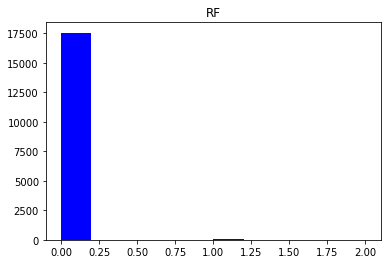

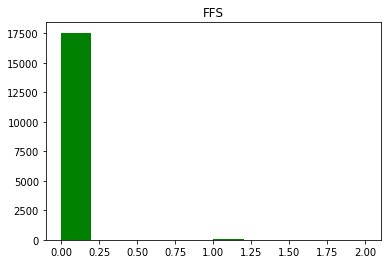

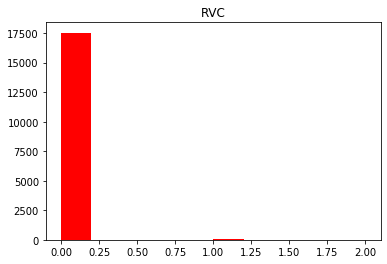

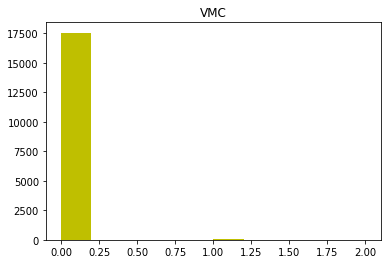

In [224]:
for name, color in zip(metric_names, ['b','g','r','y']):
    plt.hist(full_results[name], color=color)
    plt.title(name)
    plt.show()

Text(0.5, 1.0, 'Time per question sequence')

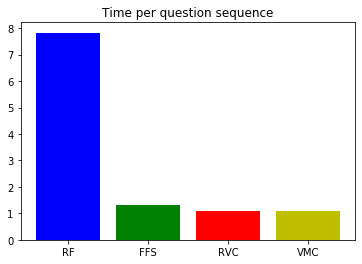

In [225]:
plt.bar(times.keys(), times.values(), color = ['b','g','r','y'])
plt.title('Time per question sequence')

Text(0.5, 1.0, 'Average amount of questions')

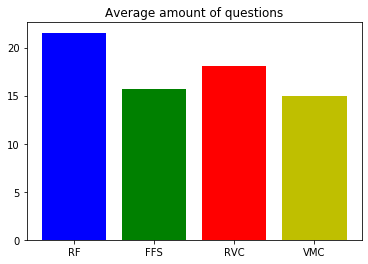

In [226]:
plt.bar(question_counts.keys(), [np.mean(v) for v in question_counts.values()], color = ['b','g','r','y'])
plt.title('Average amount of questions')

Text(0.5, 1.0, 'Minimum amount of questions')

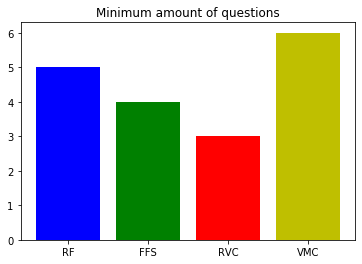

In [227]:
plt.bar(question_counts.keys(), [np.min(v) for v in question_counts.values()], color = ['b','g','r','y'])
plt.title('Minimum amount of questions')

Text(0.5, 1.0, 'Maximum amount of questions')

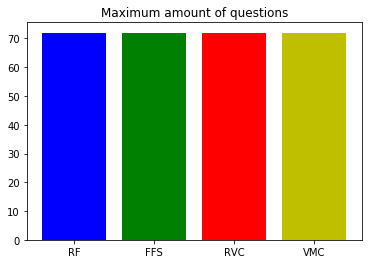

In [228]:
plt.bar(question_counts.keys(), [np.max(v) for v in question_counts.values()], color = ['b','g','r','y'])
plt.title('Maximum amount of questions')

Text(0.5, 1.0, 'Standard deviation of amount of questions')

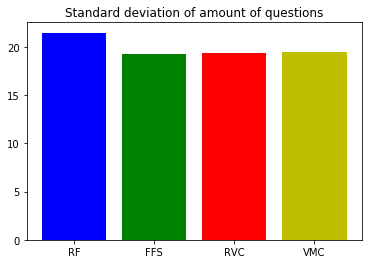

In [229]:
plt.bar(question_counts.keys(), [np.std(v) for v in question_counts.values()], color = ['b','g','r','y'])
plt.title('Standard deviation of amount of questions')

In [96]:
import random as rd

In [97]:
p = 0.04

In [132]:
def simu(p):
    c = np.zeros(4, dtype=int)
    i = 0
    while c.sum() < 4:
        for k in range(4):
            if rd.random() < p and c[k] < 1:
                c[k] = 1
        i += 1
    return i

In [133]:
a = []
for _ in range(10000):
    a.append(simu(p))

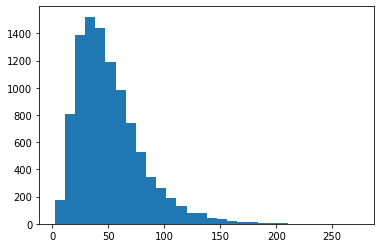

In [134]:
plt.hist(a, bins=30)
plt.show()

In [135]:
np.mean(a)

51.1422

In [136]:
p = 0.0015

In [139]:
def simu(p):
    i = 0
    while True:
        i += 1
        for _ in range(4):
            if rd.random() < p:
                return i

In [206]:
simu(p)

479

In [213]:
a = []
for _ in range(10000):
    a.append(simu(p))

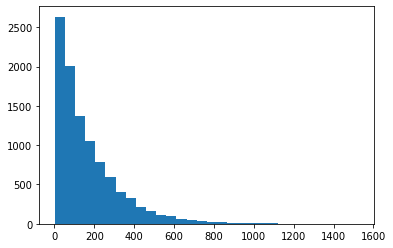

In [214]:
plt.hist(a, bins=30)
plt.show()

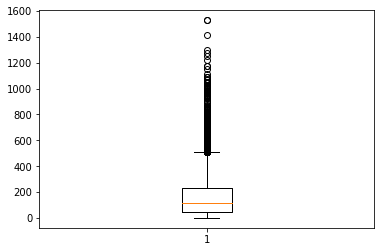

In [220]:
plt.boxplot(a)
plt.show()

In [221]:
a = np.array(a)

In [232]:
np.quantile(a,0.5)

116.0

In [239]:
pow(2,40)

1099511627776